# Table of contents
1. [Introduction: Business Problem](#introduction)
2. [Data Gathering](#Data_Gathering)
3. [Problem Solving Methodology](#Methodology)
4. [Analysis & Results](#Analysis_Results)
    1. [Analysis](#Analysis)
    2. [Results](#Results)
5. [Discussion](#Discussion)
6. [Conclusion](#Conclusion)

## This is the introduction <a name="introduction"></a>
Some introduction text, formatted in heading 2 style


## 1. Introduction: Business Problem  <a name="introduction"></a>

This project deals with discussing the neighborhoods of Chennai, Tamilnadu in India. This project would specifically help Business community planning to start Restaurants, Hotels, Café etc. in Chennai

The Foursquare API is used to access the venues in the neighborhoods. Since, it returns less venues in the neighborhoods, we would be analyzing areas for which countable number of venues are obtained. Then they are clustered based on their venues using Data Science Techniques. Here the k-means clustering algorithm is used to achieve the task. The optimal number of clusters can be obtained using silhouette score. Folium visualization library can be used to visualize the clusters superimposed on the map of Chennai city. 
These clusters will be further analyzed to help business owners selecting a potential location to open-up Hotels, Shopping Malls, Restaurants or Coffee shops.


### Importing the required libraries

In [1]:
import numpy as np
import re
import json
import requests
from bs4 import BeautifulSoup

import pandas as pd
#display all rows
pd.set_option('display.max_rows', None)
#display all columns
pd.set_option('display.max_columns', None)

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

from geopy.geocoders import Nominatim

import folium

import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
%matplotlib inline

print('Libraries imported.')

Libraries imported.


## 2. Data Gathering <a name="Data_Gathering"></a>

Chennai has multiple potential neighborhoods. Let’s use the following dataset with data wrangling and beautification techniques to produce meaningful information.

##### Loading Data from various sources
 Chennai Neighborhood data with their Latitude and Longitude from below path and then converting html data into a data frame (table). \
 https://chennaiiq.com/chennai/latitude_longitude_areas.asp
 
 
But the Latitude and Longitude data provided here is in Degrees Minute Seconds format. Thus before starting the analysis, the location data has to be converted to Decimal Degrees. Let's First, review the the html file.

In [2]:
url = 'https://chennaiiq.com/chennai/latitude_longitude_areas.asp'

html = requests.get(url)
print(html)

<Response [200]>


A Reponse value of **200** shows that the process was successful. Now we need to clean the file to access the Neighborhoods and their Locations. Lets use BeautifulSoup library to parse the html file in order to make it easier to access.

In [3]:
soup = BeautifulSoup(html.text, 'html.parser')
table = soup.find("table", attrs={"class": "TBox"})


The html has been parsed and it can be used to build the dataset. Let us access the Location data and store it in a pandas dataframe, chennai_data.

##### Data Wrangling

In [4]:
table_data = []
index = ['S.No.', 'Location', 'Latitude', 'Longitude']
for tr in table.find_all("tr", attrs={"class": "tab"}):
    t_row = {}
    for td, th in zip(tr.find_all("td"), index): 
        t_row[th] = td.text.replace('\n', '').strip()
    table_data.append(t_row)

chennai_data = pd.DataFrame(table_data[:-1], columns=index)
chennai_data.drop(columns=['S.No.'], inplace=True)
chennai_data.at[0,'Location'] = 'Adyar Bus Debot'
chennai_data.rename(columns={'Location': 'Neighborhood'}, inplace=True)
print(chennai_data.shape)
chennai_data.head()

(105, 3)


,Neighborhood,Latitude,Longitude
0,Adyar Bus Debot,"12°59'50"" N","80°15'25"" E"
1,Adyar Signal,"13°00'23"" N","80°15'27"" E"
2,Alandur,"13°00'28"" N","80°12'35"" E"
3,Ambattur,"13°06'36"" N","80°10'12"" E"
4,Anna Arch,"13°04'28"" N","80°13'06"" E"


##### Convert Degrees Minute Seconds to Decimal Degrees

The **dms2dd** fucntion defined below will solve this problem.

In [5]:
def dms2dd(s):
    degrees, minutes, seconds, direction = re.split('[°\'"]+', s)
    dd = float(degrees) + float(minutes)/60 + float(seconds)/(60*60);
    if direction in ('S','W'):
        dd*= -1
    return dd

chennai_data['Latitude'] = chennai_data['Latitude'].apply(dms2dd)
chennai_data['Longitude'] = chennai_data['Longitude'].apply(dms2dd)
print(chennai_data.shape)
chennai_data.head()

(105, 3)


,Neighborhood,Latitude,Longitude
0,Adyar Bus Debot,12.997222,80.256944
1,Adyar Signal,13.006389,80.257500
2,Alandur,13.007778,80.209722
3,Ambattur,13.110000,80.170000
4,Anna Arch,13.074444,80.218333


Now that we have the neighborhoods dataset lets visualize them using Folium Library. First lets create a map of Chennai. The latitude and longitude of chennai can be obtained using the Geolocator library.

In [6]:

address = 'Chennai, Tamil Nadu'

geolocator = Nominatim(user_agent="chennai_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geographical coordinate of chennai are {}, {}.'.format(latitude, longitude))

The geographical coordinate of chennai are 13.0836939, 80.270186.


#### The Chennai Map:

In [7]:
chennai_map = folium.Map(location=[latitude, longitude], zoom_start=12
                         
                        )    
chennai_map

##### Chennai Map with the neighborhoods markers in blue

In [8]:
# add neighborhood markers to map
for lat, lng, location in zip(chennai_data['Latitude'], chennai_data['Longitude'], chennai_data['Neighborhood']):
    label = '{}'.format(location)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(chennai_map)  

chennai_map

##### Define Foursquare Credentials and Version and will hide this sensitive information

In [9]:
# @hidden_cell

CLIENT_ID = 'Z2J3DM0MFRRZ2GPBC3RLFUGHHCTVUYQ5OKYRPAFJRV20P44A'
CLIENT_SECRET = 'CKVA15FDA3S5WOKFYAMWPEO0PKTTQZLYFA2OP1BLFMX1NZ3I' 
VERSION = '20210102'
LIMIT = 100

##### Explore neighborhoods in Chennai

The following function will send a explore request for each neighborhood and return the 100 most popular places in the neighborhood around 500 meters or 1/2 KM.

In [10]:

def getNearbyVenues(names, latitudes, longitudes, radius=500, limit=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        count = 1
        while count != 5:
            try:
                results = requests.get(url).json()["response"]['groups'][0]['items']
                count = 5
            except:
                count += 1
    
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Lets use the above function on the chennai_data neighborhoods dataframe and store the venues data returned in the chennai_venues pandas dataframe.

In [11]:

chennai_venues = getNearbyVenues(names = chennai_data['Neighborhood'],
                                 latitudes = chennai_data['Latitude'],
                                 longitudes = chennai_data['Longitude']
                                 )

print(chennai_venues.shape)
chennai_venues.head()

(1167, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Adyar Bus Debot,12.997222,80.256944,Zaitoon Restaurant,12.996861,80.256178,Middle Eastern Restaurant
1,Adyar Bus Debot,12.997222,80.256944,Kuttanadu Restaurant,12.997010,80.257799,Asian Restaurant
2,Adyar Bus Debot,12.997222,80.256944,Zha Cafe,12.999730,80.254806,Café
3,Adyar Bus Debot,12.997222,80.256944,Kovai Pazhamudir Nilayam,12.996522,80.259776,Fruit & Vegetable Store
4,Adyar Bus Debot,12.997222,80.256944,Barbeque N Biryani,12.995907,80.256011,BBQ Joint


A total of **1167** venues were obtained. Now lets check the number of venues returned per neighborhood.

In [12]:
chennai_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
AVM Studio,4,4,4,4,4,4
Adyar Bus Debot,17,17,17,17,17,17
Adyar Signal,30,30,30,30,30,30
Alandur,12,12,12,12,12,12
Ambattur,2,2,2,2,2,2
Anna Arch,13,13,13,13,13,13
Anna Nagar Roundana,20,20,20,20,20,20
Anna Nagar West Terminus,8,8,8,8,8,8
Anna Statue,14,14,14,14,14,14


From the above dataframe we can see that **Taj Coromandal** returned the highest number of venues i.e. 51. Now lets check the unique categories of all the venues returned.

In [13]:
print('There are {} uniques categories.'.format(len(chennai_venues['Venue Category'].unique())))

There are 148 uniques categories.


## 3. Problem Solving Methodology <a name="Methodology"></a>

Now, we have the neighborhoods data of chennai (i.e. total 105 neighborhoods). We also have the most popular venues in each neighborhood obtained using Foursquare API. A total of ***1167 venues*** have been obtained in the whole city and ***148 unique categories***. But as seen we have multiple neighborhoods with less than 10 venues returned. In order to create a good analysis let's consider only the neighborhoods with more than 10 venues.

We can perform one hot encoding on the obtained data set and use it find the 10 most common venue category in each neighborhood. Then clustering can be performed on the dataset.\
K - Nearest Neighbor clustering technique have been used and to find the optimal number of clusters silhouette score metric technique is used.
The clusters obtained can be analyzed to find the major type of venue categories in each cluster. The outcome then can be used to suggest business people, potential locations based on the category.

## 4. Analysis & Results <a name="Analysis_Results"></a>

### 4.1 Analysis  <a name="Analysis"></a>

Lets visualize the number of venues obtained in all the neighborhoods of Chennai.

<AxesSubplot:xlabel='Neighborhood'>

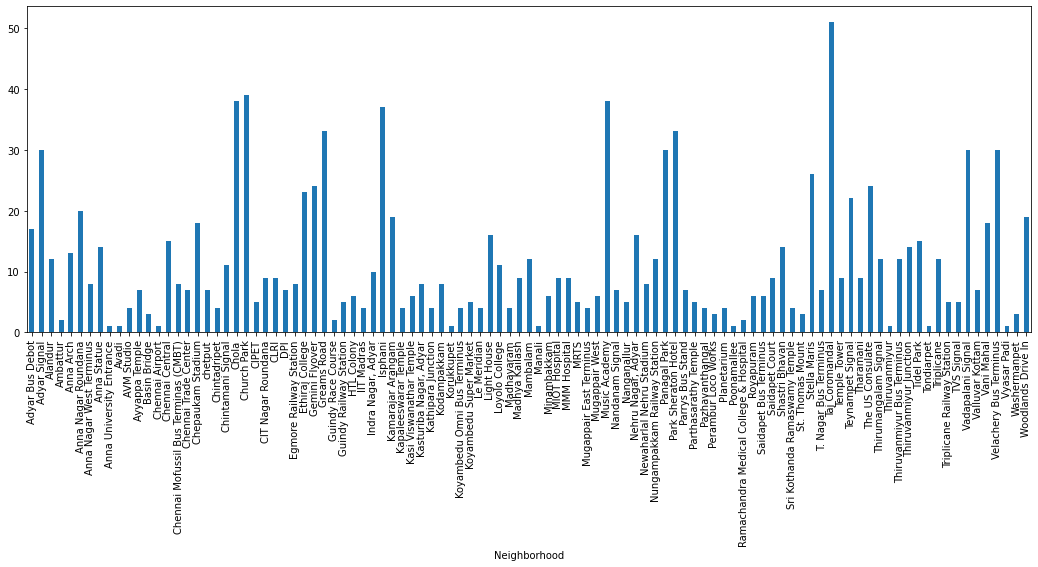

In [14]:
df = chennai_venues.groupby(['Neighborhood'], sort=False)['Venue'].count()
df.plot.bar(figsize=(18,6))

As we can see from the above bar chart, there are many neighborhoods with less than 10 venues which can be remove before performing the analysis to obtain better results. The following plot shows only the neighborhoods from which 10 or more than 10 venues were obtained.

<AxesSubplot:xlabel='Neighborhood'>

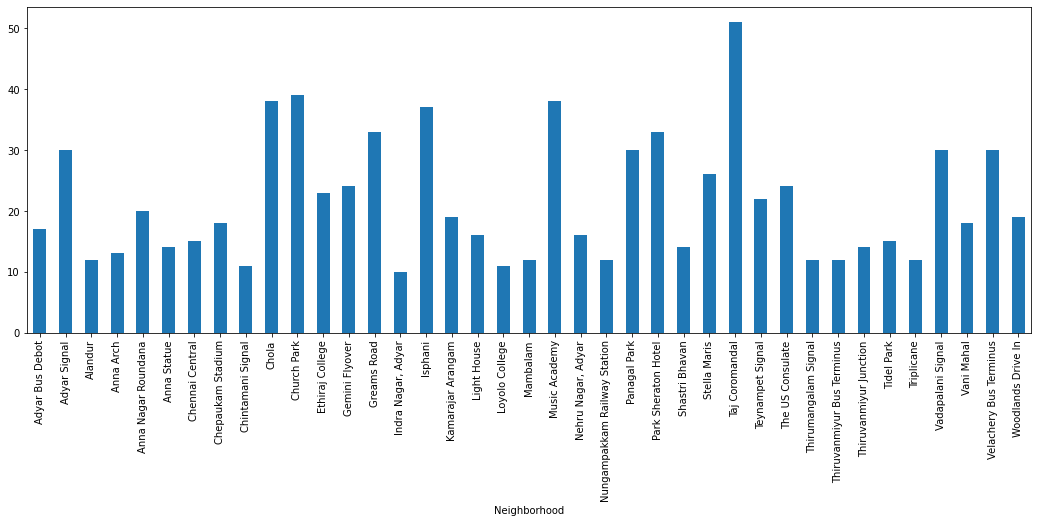

In [15]:
df = df[df >= 10]
df.plot.bar(figsize=(18,6))

Lets create a new dataframe, chennai_venues_top that contains only the neighborhoods with 10+ venues and the venues with their details included.

In [16]:
chennai_venues_top = chennai_venues[chennai_venues['Neighborhood'].isin(df.index.tolist())]
chennai_venues_top.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Adyar Bus Debot,12.997222,80.256944,Zaitoon Restaurant,12.996861,80.256178,Middle Eastern Restaurant
1,Adyar Bus Debot,12.997222,80.256944,Kuttanadu Restaurant,12.997010,80.257799,Asian Restaurant
2,Adyar Bus Debot,12.997222,80.256944,Zha Cafe,12.999730,80.254806,Café
3,Adyar Bus Debot,12.997222,80.256944,Kovai Pazhamudir Nilayam,12.996522,80.259776,Fruit & Vegetable Store
4,Adyar Bus Debot,12.997222,80.256944,Barbeque N Biryani,12.995907,80.256011,BBQ Joint


#### ***One-Hot Incoding***

In [17]:

chennai_onehot = pd.get_dummies(chennai_venues_top['Venue Category'], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
chennai_onehot['Neighborhood'] = chennai_venues_top['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = chennai_onehot.columns.tolist()
fixed_columns.insert(0, fixed_columns.pop(fixed_columns.index('Neighborhood')))
chennai_onehot = chennai_onehot.reindex(columns = fixed_columns)

print(chennai_onehot.shape)
chennai_onehot.head()

(840, 117)


,Neighborhood,Accessories Store,African Restaurant,Airport,American Restaurant,Amphitheater,Arcade,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bakery,Bank,Bar,Beach,Bengali Restaurant,Bistro,Bookstore,Boutique,Bowling Alley,Breakfast Spot,Buffet,Bus Line,Bus Station,Business Service,Cafeteria,Café,Chinese Restaurant,Chocolate Shop,Clothing Store,Coffee Shop,Comfort Food Restaurant,Concert Hall,Convenience Store,Cosmetics Shop,Department Store,Dessert Shop,Diner,Donut Shop,Electronics Store,Farmers Market,Fast Food Restaurant,Flea Market,Food,Food Court,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,General Entertainment,Gourmet Shop,Grocery Store,Gym,Hookah Bar,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indian Sweet Shop,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Kebab Restaurant,Kerala Restaurant,Korean Restaurant,Liquor Store,Lounge,Market,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Movie Theater,Multicuisine Indian Restaurant,Multiplex,Music Store,Music Venue,Nightclub,North Indian Restaurant,Office,Paper / Office Supplies Store,Park,Pharmacy,Pizza Place,Platform,Pool,Print Shop,Pub,Recreation Center,Restaurant,Rock Club,Russian Restaurant,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Shopping Mall,Smoke Shop,Snack Place,South Indian Restaurant,Spa,Sporting Goods Shop,Steakhouse,Tea Room,Thai Restaurant,Theater,Toy / Game Store,Train,Train Station,Vegetarian / Vegan Restaurant,Women's Store
0,Adyar Bus Debot,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Adyar Bus Debot,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Adyar Bus Debot,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Adyar Bus Debot,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Adyar Bus Debot,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Lets group the data by neighborhood and taking the mean value of the frequency of occurrence of each category.

In [18]:
chennai_grouped = chennai_onehot.groupby('Neighborhood').mean().reset_index()
print(chennai_grouped.shape)
chennai_grouped.head()

(39, 117)


,Neighborhood,Accessories Store,African Restaurant,Airport,American Restaurant,Amphitheater,Arcade,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bakery,Bank,Bar,Beach,Bengali Restaurant,Bistro,Bookstore,Boutique,Bowling Alley,Breakfast Spot,Buffet,Bus Line,Bus Station,Business Service,Cafeteria,Café,Chinese Restaurant,Chocolate Shop,Clothing Store,Coffee Shop,Comfort Food Restaurant,Concert Hall,Convenience Store,Cosmetics Shop,Department Store,Dessert Shop,Diner,Donut Shop,Electronics Store,Farmers Market,Fast Food Restaurant,Flea Market,Food,Food Court,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,General Entertainment,Gourmet Shop,Grocery Store,Gym,Hookah Bar,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indian Sweet Shop,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Kebab Restaurant,Kerala Restaurant,Korean Restaurant,Liquor Store,Lounge,Market,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Movie Theater,Multicuisine Indian Restaurant,Multiplex,Music Store,Music Venue,Nightclub,North Indian Restaurant,Office,Paper / Office Supplies Store,Park,Pharmacy,Pizza Place,Platform,Pool,Print Shop,Pub,Recreation Center,Restaurant,Rock Club,Russian Restaurant,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Shopping Mall,Smoke Shop,Snack Place,South Indian Restaurant,Spa,Sporting Goods Shop,Steakhouse,Tea Room,Thai Restaurant,Theater,Toy / Game Store,Train,Train Station,Vegetarian / Vegan Restaurant,Women's Store
0,Adyar Bus Debot,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.117647,0.0,0.058824,0.058824,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.058824,0.0,0.000000,0.058824,0.0,0.0,0.058824,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.117647,0.0,0.000000,0.0,0.058824,0.058824,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.00,0.000000,0.176471,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.058824,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.00,0.0,0.0,0.058824,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.058824,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0
1,Adyar Signal,0.0,0.0,0.000000,0.0,0.0,0.033333,0.0,0.033333,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.033333,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.033333,0.0,0.0,0.000000,0.033333,0.0,0.0,0.0,0.0,0.0,0.033333,0.0,0.0,0.066667,0.0,0.033333,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.033333,0.0,0.0,0.000000,0.00,0.033333,0.300000,0.0,0.033333,0.0,0.033333,0.033333,0.0,0.0,0.0,0.0,0.033333,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.033333,0.0,0.000000,0.0,0.0,0.0,0.066667,0.0,0.00,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.033333,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.033333,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.033333,0.0
2,Alandur,0.0,0.0,0.083333,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.083333,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.083333,0.166667,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.166667,0.00,0.000000,0.166667,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.083333,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.00,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.083333,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.083333,0.0,0.000000,0.0
3,Anna Arch,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.076923,0.0,0.000000,0.0,0.0,0.0,0.076923,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.076923,0.0,0.0,0.076923,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.076923,0.0,0.153846,0.0,0.076923,0.0,0.000000,0.00000

The following function returns the **top_venues** of each neighborhood.

In [19]:

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Lets use the above function to obtaine the 10 most common venues in each neighborhood and store in the new pandas dataframe *neighborhoods_venues_sorted*.

In [20]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create column names according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = chennai_grouped['Neighborhood']

for ind in np.arange(chennai_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(chennai_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adyar Bus Debot,Indian Restaurant,Fast Food Restaurant,Asian Restaurant,Pizza Place,Fried Chicken Joint,Bus Station,Sandwich Place,Fruit & Vegetable Store,Café,Middle Eastern Restaurant
1,Adyar Signal,Indian Restaurant,Electronics Store,North Indian Restaurant,Rock Club,Movie Theater,Coffee Shop,Grocery Store,Bookstore,Snack Place,Ice Cream Shop
2,Alandur,Hotel,Indian Restaurant,Bus Station,South Indian Restaurant,Bar,Metro Station,Train,Airport,Bus Line,Nightclub
3,Anna Arch,Fast Food Restaurant,Shopping Mall,Scenic Lookout,Bookstore,Multiplex,Food,Sporting Goods Shop,Bakery,Café,Clothing Store
4,Anna Nagar Roundana,Indian Restaurant,Chinese Restaurant,Juice Bar,South Indian Restaurant,Electronics Store,Fast Food Restaurant,Coffee Shop,Clothing Store,Café,Bookstore



Cluster Neighborhoods
Here k-Nearest Neighborhoods clustering technique is used. I will  use the **silhouette_score** to obtain the best value for the number of clusters.

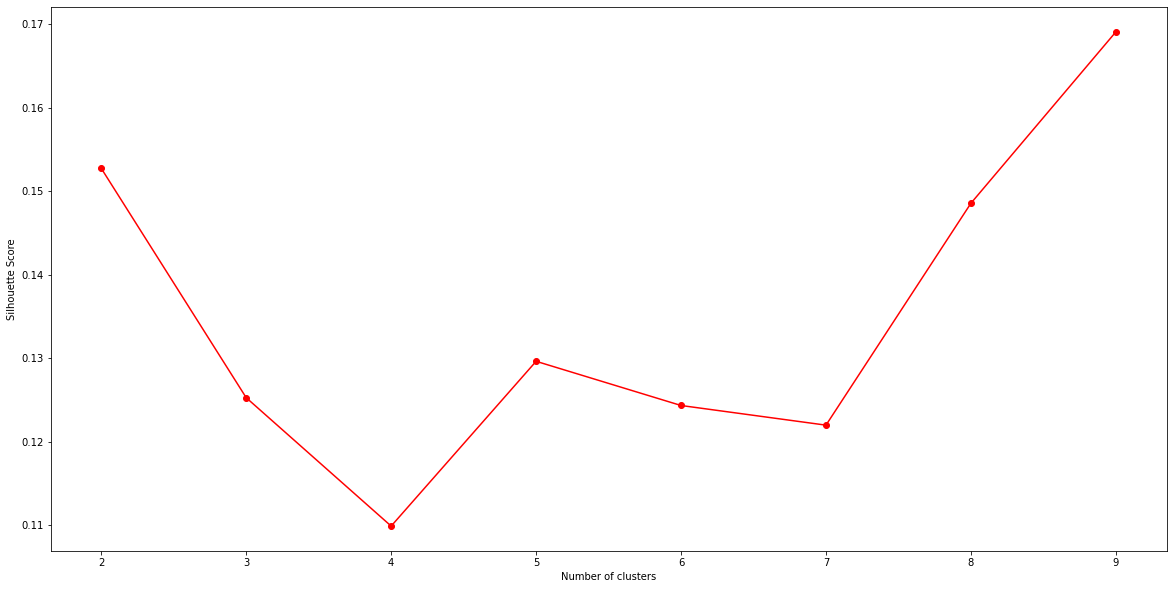

In [21]:
chennai_grouped_clustering = chennai_grouped.drop('Neighborhood', 1)

max_score = 10
scores = []

for kclusters in range(2, max_score):
    # Run k-means clustering
    kmeans = KMeans(n_clusters = kclusters, init = 'k-means++', random_state = 0).fit_predict(chennai_grouped_clustering)
    
    # Gets the silhouette score
    score = silhouette_score(chennai_grouped_clustering, kmeans)
    scores.append(score)

plt.figure(figsize=(20,10))
plt.plot(np.arange(2, max_score), scores, 'ro-')
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette Score")
plt.xticks(np.arange(2, max_score))
plt.show()

As seen from the above line plot, the best number of clusters having the **highest silhouette score is 9**. So, lets consider the number of clusters as 8.

In [22]:
chennai_grouped_clustering = chennai_grouped.drop('Neighborhood', 1)

# Use silhouette score to find optimal number of clusters to segment the data
kclusters = np.arange(2,10)
results = {}
for size in kclusters:
    model = KMeans(n_clusters = size).fit(chennai_grouped_clustering)
    predictions = model.predict(chennai_grouped_clustering)
    results[size] = silhouette_score(chennai_grouped_clustering, predictions)

best_size = max(results, key=results.get)
best_size

9

In [23]:
# select best number of clusters
kclusters = 9

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(chennai_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 5, 0, 4, 5, 3, 0, 5, 5, 0], dtype=int32)

Add the cluster labels to the neighborhoods_venues_sorted dataframe. And lets create a new datframe chennai_merged which has the neighborhood details, **cluster labels** and the 10 most common venues in that neighborhood.

In [24]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

chennai_merged = chennai_venues_top[chennai_venues_top.columns[0:3]].drop_duplicates()
chennai_merged.reset_index(drop = True, inplace = True)

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
chennai_merged = chennai_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

chennai_merged.head(1000)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adyar Bus Debot,12.997222,80.256944,0,Indian Restaurant,Fast Food Restaurant,Asian Restaurant,Pizza Place,Fried Chicken Joint,Bus Station,Sandwich Place,Fruit & Vegetable Store,Café,Middle Eastern Restaurant
1,Adyar Signal,13.006389,80.257500,5,Indian Restaurant,Electronics Store,North Indian Restaurant,Rock Club,Movie Theater,Coffee Shop,Grocery Store,Bookstore,Snack Place,Ice Cream Shop
2,Alandur,13.007778,80.209722,0,Hotel,Indian Restaurant,Bus Station,South Indian Restaurant,Bar,Metro Station,Train,Airport,Bus Line,Nightclub
3,Anna Arch,13.074444,80.218333,4,Fast Food Restaurant,Shopping Mall,Scenic Lookout,Bookstore,Multiplex,Food,Sporting Goods Shop,Bakery,Café,Clothing Store
4,Anna Nagar Roundana,13.084444,80.218056,5,Indian Restaurant,Chinese Restaurant,Juice Bar,South Indian Restaurant,Electronics Store,Fast Food Restaurant,Coffee Shop,Clothing Store,Café,Bookstore
5,Anna Statue,13.068056,80.271944,3,Indian Restaurant,Multiplex,Electronics Store,Dessert Shop,General Entertainment,Flea Market,Movie Theater,Accessories Store,Mobile Phone Shop,Office
6,Chennai Central,13.082222,80.275556,0,Indian Restaurant,Bookstore,Train Station,Platform,Vegetarian / Vegan Restaurant,Nightclub,Hotel,Sandwich Place,Bus Station,Metro Station
7,Chepaukam Stadium,13.064167,80.266389,5,Indian Restaurant,Breakfast Spot,Electronics Store,Bar,Multiplex,Business Service,Bookstore,Mediterranean Restaurant,General Entertainment,Hotel
8,Chintamani Signal,13.085000,80.224167,5,Indian Restaurant,Middle Eastern Restaurant,Restaurant,Snack Place,Bakery,Coffee Shop,Nightclub,Music Venue,Mobile Phone Shop,North Indian Restaurant
9,Chola,13.044167,80.259722,0,Indian Restaurant,Hotel,Concert Hall,Restaurant,Ice Cream Shop,Lounge,South Indian Restaurant,Pub,Chinese Restaurant,Café


We will check  randomly some dataset shape.

In [25]:
chennai_merged1 = chennai_merged.loc[chennai_merged['Cluster Labels'] == 0, chennai_merged.columns[[3, 4] + list(range(5, chennai_merged.shape[1]))]]
chennai_merged1.shape

(18, 11)

In [26]:
chennai_merged2 = chennai_merged.loc[chennai_merged['Cluster Labels'] == 1, chennai_merged.columns[[3, 4] + list(range(5, chennai_merged.shape[1]))]]
chennai_merged2.shape

(4, 11)

We can also visualie the density of Neighborhood by cluster label in a chart below.

<AxesSubplot:ylabel='Cluster Labels'>

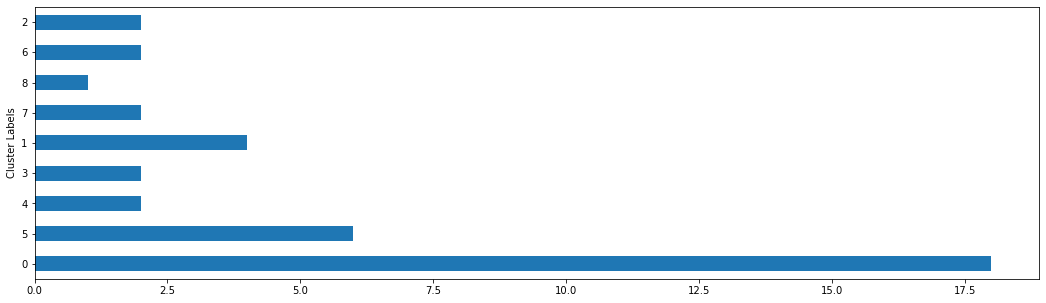

In [27]:
df = chennai_merged.groupby(['Cluster Labels'], sort=False)['Neighborhood'].count()
df.plot.barh(figsize=(18,5))

As we can see in above datframe **Cluster 0** Contains the highest cluster density. We need to find the geographic centroid for this cluster. This is the most suitable  location for a new business set-up

In [28]:
Cluster_0_coorid = chennai_merged[['Neighborhood Latitude', 'Neighborhood Longitude']]
Cluster_0_coorid = list(Cluster_0_coorid.values) 
lat = []
long = []



for l in Cluster_0_coorid:
  lat.append(l[0])
  long.append(l[1])



Blatitude = sum(lat)/len(lat)
Blongitude = sum(long)/len(long)
print(Blatitude)
print(Blongitude)

13.042777777777774
80.24602564102565


***Install opencage to reverse lookup the coordinates***

In [29]:
# Intstall opencage to reverse lookup the cooridinates
!pip install opencage
from opencage.geocoder import OpenCageGeocode
from pprint import pprint

# @hidden_cell
key = '3a99b5016d2d4afbb5d9456248a2e58f'
geocoder = OpenCageGeocode(key)

results = geocoder.reverse_geocode(Blatitude, Blongitude)
pprint(results)


[{'annotations': {'DMS': {'lat': "13° 2' 32.78508'' N",
                          'lng': "80° 14' 45.49380'' E"},
                  'MGRS': '44PMV1824341950',
                  'Maidenhead': 'NK03cb90me',
                  'Mercator': {'x': 8932940.577, 'y': 1454944.6},
                  'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?way=206676219#map=16/13.04244/80.24597',
                          'note_url': 'https://www.openstreetmap.org/note/new#map=16/13.04244/80.24597&layers=N',
                          'url': 'https://www.openstreetmap.org/?mlat=13.04244&mlon=80.24597#map=16/13.04244/80.24597'},
                  'UN_M49': {'regions': {'ASIA': '142',
                                         'IN': '356',
                                         'SOUTHERN_ASIA': '034',
                                         'WORLD': '001'},
                             'statistical_groupings': ['LEDC']},
                  'callingcode': 91,
                  'currency': {'alternate_sy

In [30]:

#Obtain the popupstring of the best location
popstring = chennai_data[chennai_data['Neighborhood'].str.contains('Teynam')]

def str_join(*args):
    return ''.join(map(str, args))

popstring_new = str_join('The Best suitable Neighbourhood to locate a New Business is in: ', popstring['Neighborhood'].values)


print(popstring_new)

The Best suitable Neighbourhood to locate a New Business is in: ['Teynampet Signal']


In [31]:
address = 'Chennai, Tamil Nadu'

geolocator = Nominatim(user_agent="Project 3A99B5")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geographical coordinate of chennai are {}, {}.'.format(latitude, longitude))

The geographical coordinate of chennai are 13.0836939, 80.270186.


### 4.2 Results  <a name="Results"></a>

We need to dig more to find out compilmentary business set-ups in each clusters in oreder to suggest a most suitable custer for new bsuiness set-up. So Let’s examine the clusters and find the discriminating venue categories that distinguish each cluster. For this purpose lets also print the ten most common venue category in each cluster.

#### Cluster 1

In [32]:
chennai_merged.loc[chennai_merged['Cluster Labels'] == 0, chennai_merged.columns[[0] + list(range(4, chennai_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adyar Bus Debot,Indian Restaurant,Fast Food Restaurant,Asian Restaurant,Pizza Place,Fried Chicken Joint,Bus Station,Sandwich Place,Fruit & Vegetable Store,Café,Middle Eastern Restaurant
2,Alandur,Hotel,Indian Restaurant,Bus Station,South Indian Restaurant,Bar,Metro Station,Train,Airport,Bus Line,Nightclub
6,Chennai Central,Indian Restaurant,Bookstore,Train Station,Platform,Vegetarian / Vegan Restaurant,Nightclub,Hotel,Sandwich Place,Bus Station,Metro Station
9,Chola,Indian Restaurant,Hotel,Concert Hall,Restaurant,Ice Cream Shop,Lounge,South Indian Restaurant,Pub,Chinese Restaurant,Café
11,Ethiraj College,Indian Restaurant,Hotel,Kebab Restaurant,Pizza Place,Juice Bar,Café,Mexican Restaurant,Donut Shop,Fast Food Restaurant,Restaurant
12,Gemini Flyover,Indian Restaurant,Sandwich Place,Coffee Shop,Nightclub,Hotel,Bar,Café,Park,South Indian Restaurant,Bengali Restaurant
15,Isphani,Indian Restaurant,Hotel,Chinese Restaurant,South Indian Restaurant,Lounge,Nightclub,Pizza Place,Coffee Shop,Café,Sandwich Place
16,Kamarajar Arangam,Café,Indian Restaurant,Lounge,Hotel,Nightclub,Park,South Indian Restaurant,BBQ Joint,Pizza Place,Coffee Shop
20,Music Academy,Indian Restaurant,Hotel,Restaurant,Concert Hall,Café,Women's Store,Fruit & Vegetable Store,Pub,Comfort Food Restaurant,Dessert Shop
24,Park Sheraton Hotel,Café,Hotel,Nightclub,Restaurant,Japanese Restaurant,Italian Restaurant,Thai Restaurant,Indian Restaurant,Coffee Shop,Chinese Restaurant


In [33]:
cluster1 = chennai_merged.loc[chennai_merged['Cluster Labels'] == 0, chennai_merged.columns[[0] + 
                                                                                    list(range(4, chennai_merged.shape[1]))]]
venues1 = (cluster1['1st Most Common Venue'].append(
    cluster1['2nd Most Common Venue']).append(
    cluster1['3rd Most Common Venue']).append(
    cluster1['4th Most Common Venue']).append(
    cluster1['5th Most Common Venue']).append(
    cluster1['6th Most Common Venue']).append(
    cluster1['7th Most Common Venue']).append(
    cluster1['8th Most Common Venue']).append(
    cluster1['9th Most Common Venue']).append(
    cluster1['10th Most Common Venue']))

print(venues1.value_counts().head(10))

Indian Restaurant          18
Hotel                      15
Café                       12
Nightclub                   8
Pizza Place                 7
Chinese Restaurant          7
South Indian Restaurant     7
Sandwich Place              7
Coffee Shop                 7
Restaurant                  5
dtype: int64


#### Cluster 2

In [34]:
chennai_merged.loc[chennai_merged['Cluster Labels'] == 1, chennai_merged.columns[[0] + list(range(4, chennai_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
10,Church Park,Multiplex,Indian Restaurant,Bakery,Movie Theater,Café,Chinese Restaurant,Middle Eastern Restaurant,Hotel,Mobile Phone Shop,Gaming Cafe
13,Greams Road,Multiplex,Café,Middle Eastern Restaurant,Indian Restaurant,Juice Bar,Movie Theater,Bakery,Kebab Restaurant,Pub,Restaurant
31,Thiruvanmiyur Bus Terminus,Indian Restaurant,Multiplex,Pharmacy,Vegetarian / Vegan Restaurant,Department Store,Pizza Place,Hotel Bar,Hotel,Gym,Chinese Restaurant
32,Thiruvanmiyur Junction,Indian Restaurant,Indian Sweet Shop,Chinese Restaurant,Hotel Bar,Hotel,Gym,Multiplex,Paper / Office Supplies Store,Juice Bar,Clothing Store


In [35]:
cluster2 = chennai_merged.loc[chennai_merged['Cluster Labels'] == 1, chennai_merged.columns[[0] + 
                                                                                    list(range(4, chennai_merged.shape[1]))]]
venues2 = (cluster2['1st Most Common Venue'].append(
    cluster2['2nd Most Common Venue']).append(
    cluster2['3rd Most Common Venue']).append(
    cluster2['4th Most Common Venue']).append(
    cluster2['5th Most Common Venue']).append(
    cluster2['6th Most Common Venue']).append(
    cluster2['7th Most Common Venue']).append(
    cluster2['8th Most Common Venue']).append(
    cluster2['9th Most Common Venue']).append(
    cluster2['10th Most Common Venue']))

print(venues2.value_counts().head(10))

Multiplex                    4
Indian Restaurant            4
Chinese Restaurant           3
Hotel                        3
Juice Bar                    2
Café                         2
Middle Eastern Restaurant    2
Hotel Bar                    2
Movie Theater                2
Bakery                       2
dtype: int64


#### Cluster 3

In [36]:
chennai_merged.loc[chennai_merged['Cluster Labels'] == 2, chennai_merged.columns[[0] + list(range(4, chennai_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
19,Mambalam,Clothing Store,Indian Restaurant,Department Store,South Indian Restaurant,Asian Restaurant,Boutique,Jewelry Store,Office,Paper / Office Supplies Store,North Indian Restaurant
23,Panagal Park,Clothing Store,Indian Restaurant,Jewelry Store,South Indian Restaurant,Miscellaneous Shop,Park,Dessert Shop,Pizza Place,Coffee Shop,Café


In [37]:

cluster3 = chennai_merged.loc[chennai_merged['Cluster Labels'] == 2, chennai_merged.columns[[0] + 
                                                                                    list(range(4, chennai_merged.shape[1]))]]
venues3 = (cluster3['1st Most Common Venue'].append(
    cluster3['2nd Most Common Venue']).append(
    cluster3['3rd Most Common Venue']).append(
    cluster3['4th Most Common Venue']).append(
    cluster3['5th Most Common Venue']).append(
    cluster3['6th Most Common Venue']).append(
    cluster3['7th Most Common Venue']).append(
    cluster3['8th Most Common Venue']).append(
    cluster3['9th Most Common Venue']).append(
    cluster3['10th Most Common Venue']))

print(venues3.value_counts().head(10))

South Indian Restaurant          2
Indian Restaurant                2
Clothing Store                   2
Jewelry Store                    2
Paper / Office Supplies Store    1
Dessert Shop                     1
Café                             1
Boutique                         1
Coffee Shop                      1
Asian Restaurant                 1
dtype: int64


#### Cluster 4

In [38]:
chennai_merged.loc[chennai_merged['Cluster Labels'] == 3, chennai_merged.columns[[0] + list(range(4, chennai_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Anna Statue,Indian Restaurant,Multiplex,Electronics Store,Dessert Shop,General Entertainment,Flea Market,Movie Theater,Accessories Store,Mobile Phone Shop,Office
34,Triplicane,Indian Restaurant,Multiplex,Hotel,Dessert Shop,Electronics Store,General Entertainment,Accessories Store,Mobile Phone Shop,Office,North Indian Restaurant


In [39]:

cluster4 = chennai_merged.loc[chennai_merged['Cluster Labels'] == 3, chennai_merged.columns[[0] + 
                                                                                    list(range(4, chennai_merged.shape[1]))]]
venues4 = (cluster4['1st Most Common Venue'].append(
    cluster4['2nd Most Common Venue']).append(
    cluster4['3rd Most Common Venue']).append(
    cluster4['4th Most Common Venue']).append(
    cluster4['5th Most Common Venue']).append(
    cluster4['6th Most Common Venue']).append(
    cluster4['7th Most Common Venue']).append(
    cluster4['8th Most Common Venue']).append(
    cluster4['9th Most Common Venue']).append(
    cluster4['10th Most Common Venue']))

print(venues4.value_counts().head(10))

Mobile Phone Shop          2
Dessert Shop               2
Office                     2
General Entertainment      2
Indian Restaurant          2
Electronics Store          2
Accessories Store          2
Multiplex                  2
Hotel                      1
North Indian Restaurant    1
dtype: int64


#### Cluster 6

In [40]:
chennai_merged.loc[chennai_merged['Cluster Labels'] == 4, chennai_merged.columns[[0] + list(range(4, chennai_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Anna Arch,Fast Food Restaurant,Shopping Mall,Scenic Lookout,Bookstore,Multiplex,Food,Sporting Goods Shop,Bakery,Café,Clothing Store
35,Vadapalani Signal,Multiplex,Clothing Store,Hotel,Fast Food Restaurant,Vegetarian / Vegan Restaurant,Asian Restaurant,Indian Restaurant,South Indian Restaurant,Furniture / Home Store,Café


In [41]:
cluster5 = chennai_merged.loc[chennai_merged['Cluster Labels'] == 4, chennai_merged.columns[[0] + 
                                                                                    list(range(4, chennai_merged.shape[1]))]]
venues5 = (cluster5['1st Most Common Venue'].append(
    cluster5['2nd Most Common Venue']).append(
    cluster5['3rd Most Common Venue']).append(
    cluster5['4th Most Common Venue']).append(
    cluster5['5th Most Common Venue']).append(
    cluster5['6th Most Common Venue']).append(
    cluster5['7th Most Common Venue']).append(
    cluster5['8th Most Common Venue']).append(
    cluster5['9th Most Common Venue']).append(
    cluster5['10th Most Common Venue']))

print(venues5.value_counts().head(10))

Fast Food Restaurant             2
Café                             2
Clothing Store                   2
Multiplex                        2
South Indian Restaurant          1
Vegetarian / Vegan Restaurant    1
Food                             1
Sporting Goods Shop              1
Indian Restaurant                1
Asian Restaurant                 1
dtype: int64


#### Cluster 6

In [42]:
chennai_merged.loc[chennai_merged['Cluster Labels'] == 5, chennai_merged.columns[[0] + list(range(4, chennai_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Adyar Signal,Indian Restaurant,Electronics Store,North Indian Restaurant,Rock Club,Movie Theater,Coffee Shop,Grocery Store,Bookstore,Snack Place,Ice Cream Shop
4,Anna Nagar Roundana,Indian Restaurant,Chinese Restaurant,Juice Bar,South Indian Restaurant,Electronics Store,Fast Food Restaurant,Coffee Shop,Clothing Store,Café,Bookstore
7,Chepaukam Stadium,Indian Restaurant,Breakfast Spot,Electronics Store,Bar,Multiplex,Business Service,Bookstore,Mediterranean Restaurant,General Entertainment,Hotel
8,Chintamani Signal,Indian Restaurant,Middle Eastern Restaurant,Restaurant,Snack Place,Bakery,Coffee Shop,Nightclub,Music Venue,Mobile Phone Shop,North Indian Restaurant
25,Shastri Bhavan,Indian Restaurant,Chinese Restaurant,Japanese Restaurant,Asian Restaurant,Coffee Shop,Multicuisine Indian Restaurant,Hotel,Convenience Store,Theater,Liquor Store
37,Velachery Bus Terminus,Indian Restaurant,Fast Food Restaurant,Chinese Restaurant,Restaurant,Accessories Store,Snack Place,Kerala Restaurant,Liquor Store,Ice Cream Shop,Multiplex


In [43]:

cluster6 = chennai_merged.loc[chennai_merged['Cluster Labels'] == 5, chennai_merged.columns[[0] + 
                                                                                    list(range(4, chennai_merged.shape[1]))]]
venues6 = (cluster6['1st Most Common Venue'].append(
    cluster6['2nd Most Common Venue']).append(
    cluster6['3rd Most Common Venue']).append(
    cluster6['4th Most Common Venue']).append(
    cluster6['5th Most Common Venue']).append(
    cluster6['6th Most Common Venue']).append(
    cluster6['7th Most Common Venue']).append(
    cluster6['8th Most Common Venue']).append(
    cluster6['9th Most Common Venue']).append(
    cluster6['10th Most Common Venue']))

print(venues6.value_counts().head(10))

Indian Restaurant          6
Coffee Shop                4
Electronics Store          3
Chinese Restaurant         3
Snack Place                3
Bookstore                  3
Ice Cream Shop             2
North Indian Restaurant    2
Multiplex                  2
Fast Food Restaurant       2
dtype: int64


#### Cluster 7

In [44]:
chennai_merged.loc[chennai_merged['Cluster Labels'] == 6, chennai_merged.columns[[0] + list(range(4, chennai_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
18,Loyolo College,Department Store,Ice Cream Shop,Gourmet Shop,Café,Chinese Restaurant,South Indian Restaurant,Clothing Store,Fast Food Restaurant,Bakery,Train Station
22,Nungampakkam Railway Station,Train Station,Department Store,Clothing Store,South Indian Restaurant,Vegetarian / Vegan Restaurant,Italian Restaurant,Bus Station,Ice Cream Shop,Fast Food Restaurant,Chinese Restaurant


In [45]:

cluster7 = chennai_merged.loc[chennai_merged['Cluster Labels'] == 6, chennai_merged.columns[[0] + 
                                                                                    list(range(4, chennai_merged.shape[1]))]]
venues7 = (cluster7['1st Most Common Venue'].append(
    cluster7['2nd Most Common Venue']).append(
    cluster7['3rd Most Common Venue']).append(
    cluster7['4th Most Common Venue']).append(
    cluster7['5th Most Common Venue']).append(
    cluster7['6th Most Common Venue']).append(
    cluster7['7th Most Common Venue']).append(
    cluster7['8th Most Common Venue']).append(
    cluster7['9th Most Common Venue']).append(
    cluster7['10th Most Common Venue']))

print(venues7.value_counts().head(10))

Department Store                 2
South Indian Restaurant          2
Train Station                    2
Fast Food Restaurant             2
Chinese Restaurant               2
Ice Cream Shop                   2
Clothing Store                   2
Café                             1
Vegetarian / Vegan Restaurant    1
Italian Restaurant               1
dtype: int64


#### Cluster 8

In [46]:
chennai_merged.loc[chennai_merged['Cluster Labels'] == 7, chennai_merged.columns[[0] + list(range(4, chennai_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
14,"Indra Nagar, Adyar",Café,Women's Store,Sandwich Place,Ice Cream Shop,Department Store,Pizza Place,Chinese Restaurant,Breakfast Spot,Platform,Steakhouse
21,"Nehru Nagar, Adyar",Café,Pizza Place,Indian Restaurant,Ice Cream Shop,Chinese Restaurant,South Indian Restaurant,Department Store,Sandwich Place,Women's Store,Steakhouse


In [47]:

cluster8 = chennai_merged.loc[chennai_merged['Cluster Labels'] == 7, chennai_merged.columns[[0] + 
                                                                                    list(range(4, chennai_merged.shape[1]))]]
venues8 = (cluster8['1st Most Common Venue'].append(
    cluster8['2nd Most Common Venue']).append(
    cluster8['3rd Most Common Venue']).append(
    cluster8['4th Most Common Venue']).append(
    cluster8['5th Most Common Venue']).append(
    cluster8['6th Most Common Venue']).append(
    cluster8['7th Most Common Venue']).append(
    cluster8['8th Most Common Venue']).append(
    cluster8['9th Most Common Venue']).append(
    cluster8['10th Most Common Venue']))

print(venues8.value_counts().head(10))

Department Store      2
Chinese Restaurant    2
Café                  2
Pizza Place           2
Ice Cream Shop        2
Women's Store         2
Steakhouse            2
Sandwich Place        2
Platform              1
Breakfast Spot        1
dtype: int64


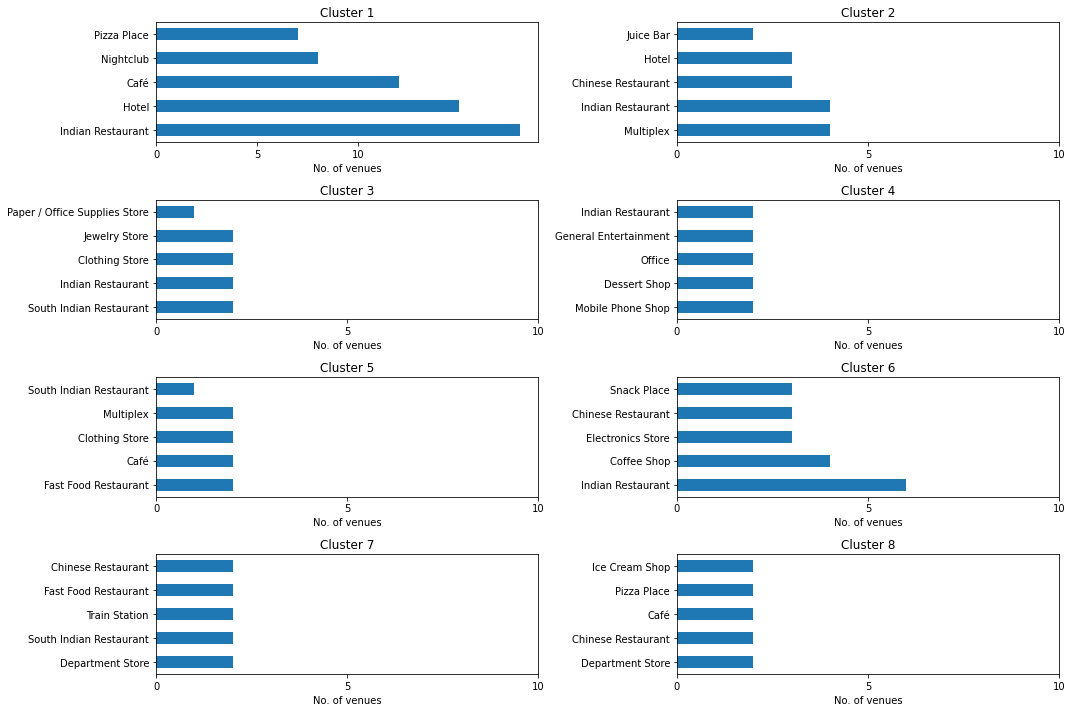

In [48]:
df_list = [venues1 ,venues2, venues3, venues4, venues5, venues6, venues7, venues8]
fig, axes = plt.subplots(4, 2)

count = 0
for r in range(4):
    for c in range(2):
        df_list[count].value_counts().head().plot.barh(ax = axes[r,c], width=0.5, figsize=(15,10))
        axes[r,c].set_title('Cluster {}'.format(count+1))
        plt.sca(axes[r, c])
        plt.xticks(np.arange(0, 15, 5))
        plt.xlabel('No. of venues')
        count += 1
        

fig.tight_layout()

These above  plots can be used to suggest valuable information to Business persons. Let's discuss a few examples considering they would like to start the following category of business.

## 5. Discussion <a name="Discussion"></a>

Let us discuss about appropriate business oportunity by Venue Category for certain targeted business set-ups.

#### A. Hotels

The neighborhoods in **cluster 1** has the greatest number of hotels,  Thus, an optimal place would be one which has less hotels, but also have restaurants and other places to explore. Considering all these facts, the best choice would be Cluster 6 and Cluster 7 as it has some local cusine restaurant whihc would attract tourists who would love to experience these.

#### B. Multiplex

The neighborhoods in **cluster 2 and 5** has notable number of Multiplexes. By using the same procedure as above, the suitable cluster would be the Cluster 1 and since it has not much shopping malls and also it has many Hotels and Restaurants which gives an advantage.

Similarly, based on the requirement suggestions can be provided about the neighborhood that would be best suitable for the business.

#### C. Buisness Stores

The neighborhoods in **cluster 3** has the greatest number of stores, Thus, an optimal place would be one which has less stores, but also have other attractions and other places to explore. Considering all these facts, the best choice would be Cluster 1 and Cluster 2 as it has some local cusine restaurant whihc would attract tourists who would love to experience these.

#### Map of Chennai with the clusters superimposed on top

This map can be used to find a suitable location to start a new business based on the Venue category.

In [49]:
# getfolium
import folium 
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(chennai_merged['Neighborhood Latitude'], chennai_merged['Neighborhood Longitude'], chennai_merged['Neighborhood'], chennai_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=3,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.8).add_to(map_clusters)
    
folium.CircleMarker([Blatitude, Blongitude],
                    radius=50,
                    popup='Chennai',
                    color='blue',
                    ).add_to(map_clusters)

# Interactive marker
map_clusters.add_child(folium.ClickForMarker(popup=popstring_new))
       
#map_clusters
map_clusters.save('map_clusters.html')


map_clusters

This map can also be used to select a vast suggestion area for a particular type of business based on the category.

## 6. Conclusion <a name="Conclusion"></a>

Objective of this project was to analyze the neighborhoods of Chennai and create a clustering model to suggest potential places to start a new business based on the category. The neighborhoods data was obtained from an online source and the Foursquare API was used to find the major venues in each neighborhood. But we found that many neighborhoods had less than 10 venues returned. In order to build an appealing recommendation model, we filtered out these locations. The remaining locations were used to create a clustering model. The best number of clusters i.e. 8 was obtained using the silhouette score. Each cluster was examined to find the most venue categories present, that defines the characteristics for that particular cluster.

A few examples for the applications that the clusters can be used for have also been discussed. A map showing the clusters have been provided. Both these can be used by stakeholders to decide the location for the particular type of business. A major drawback of this project was that the Foursquare API returned only few venues in each neighborhood. As a future improvement, better data sources can be used to obtain more venues in each neighborhood. This way the neighborhoods that were filtered out can be included in the clustering analysis to create a better decision model.

